In [144]:
import os
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

In [139]:
def extract_peaks(audio_path):
    """Loads an audio file, extracts the shock component, and returns the peak moments in seconds."""
    y, sr = librosa.load(audio_path)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    pre_max_val = 3
    post_max_val = 3
    pre_avg_val = 5
    post_avg_val = 5
    delta_val = 1.
    wait_val = 5

    peak_frames = librosa.util.peak_pick(
        onset_env,
        pre_max=pre_max_val,
        post_max=post_max_val,
        pre_avg=pre_avg_val,
        post_avg=post_avg_val,
        delta=delta_val,
        wait=wait_val
    )
    peak_times = librosa.frames_to_time(peak_frames, sr=sr)
    duration = librosa.get_duration(y=y, sr=sr)
    return peak_times, duration

def create_feature_vector(peak_times, duration):
    """Creates a normalized feature vector from the peak moments."""
    first_peak = peak_times[0]
    feature_vector = (peak_times - first_peak) / duration if duration > 0 else (peak_times - first_peak)
    return feature_vector

friendly_dir = r'knock_data\friend_knock'
enemy_dir = r'knock_data\enemy_knock'

friendly_features = []
friendly_durations = []
friendly_files = [os.path.join(friendly_dir, f) for f in os.listdir(friendly_dir) if f.endswith('.mp3')]
for file_path in friendly_files:
    peaks, duration = extract_peaks(file_path)
    features = create_feature_vector(peaks, duration)
    friendly_features.append(features)
    friendly_durations.append(duration)

enemy_features = []
enemy_durations = []
enemy_files = [os.path.join(enemy_dir, f) for f in os.listdir(enemy_dir) if f.endswith('.mp3')]
for file_path in enemy_files:
    peaks, duration = extract_peaks(file_path)
    features = create_feature_vector(peaks, duration)
    enemy_features.append(features)
    enemy_durations.append(duration)

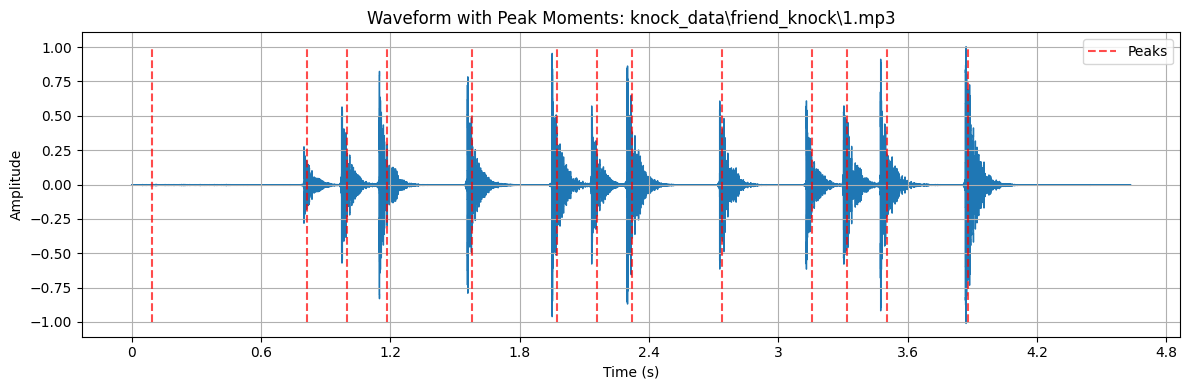

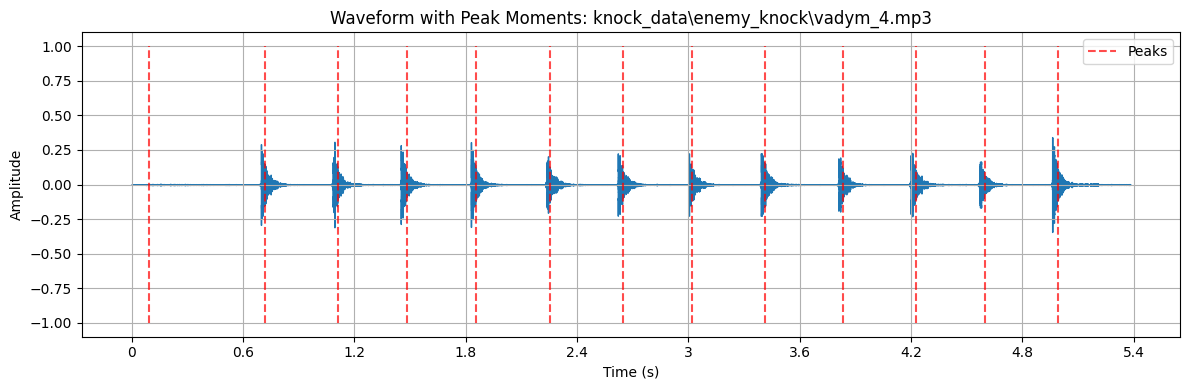

In [140]:
def visualize_peaks_waveform(audio_path, peak_times):
    y, sr = librosa.load(audio_path)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.vlines(peak_times, -1, 1, color='r', alpha=0.7, linestyle='--', label='Peaks')
    plt.title(f'Waveform with Peak Moments: {audio_path}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

audio_file = r'knock_data\friend_knock\1.mp3'
peak_times, _ = extract_peaks(audio_file)
visualize_peaks_waveform(audio_file, peak_times)

audio_file = r'knock_data\enemy_knock\vadym_4.mp3'
peak_times, _ = extract_peaks(audio_file)
visualize_peaks_waveform(audio_file, peak_times)

In [141]:
max_len_friendly = max(len(f) for f in friendly_features) if friendly_features else 0
padded_friendly_features = [np.pad(f, (0, max_len_friendly - len(f))) for f in friendly_features]
friendly_feature_matrix = np.array(padded_friendly_features) if padded_friendly_features else np.empty((0, 0))

max_len_enemy = max(len(f) for f in enemy_features) if enemy_features else 0
padded_enemy_features = [np.pad(f, (0, max_len_friendly - len(f))) for f in enemy_features]
enemy_feature_matrix = np.array(padded_enemy_features) if padded_enemy_features else np.empty((0, 0))

enemy_feature_matrix[0]

array([0.        , 0.08199084, 0.23777344, 0.26647023, 0.30336611,
       0.36485924, 0.43045191, 0.46324825, 0.50014412, 0.5657368 ,
       0.64772764, 0.68052397, 0.71332031, 0.76661435, 0.83630657,
       0.89370016, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [142]:
distances = euclidean_distances(enemy_feature_matrix, friendly_feature_matrix)
distances

array([[1.45847914, 1.23752395, 1.28959258, 1.45115665, 1.96502753,
        2.00819532, 1.47509646, 2.62464701, 1.46679163, 1.48630191,
        0.95091114, 1.94882436, 2.29313372, 1.48497079, 1.27170176,
        1.56253374, 1.45376981, 0.9703525 , 0.95546969, 1.47543197],
       [1.13824457, 0.84697533, 0.93732454, 1.11910224, 1.74070697,
        1.77523254, 1.16366081, 2.62629698, 1.15037696, 1.17812753,
        1.27497066, 2.04797469, 2.06833665, 1.17701775, 1.48376422,
        1.72213015, 1.12837938, 1.28775443, 1.26445893, 1.1644807 ],
       [1.48887516, 1.69467281, 1.8537815 , 1.4375347 , 0.28603753,
        1.01916077, 1.57074124, 2.96978096, 1.55819035, 1.52499291,
        2.23252781, 2.62644734, 1.95040356, 1.56794815, 2.30524872,
        2.44221601, 1.4998643 , 2.24435528, 2.22399953, 1.54863866],
       [0.18405421, 0.88706508, 0.9652816 , 0.40825331, 1.51477974,
        1.64726872, 0.11514205, 2.78693862, 0.15885364, 0.14729622,
        1.7539692 , 2.32321244, 2.07944007, 0

In [143]:
min_distances_to_friendly = np.min(distances, axis=1)
max_distances_to_friendly = np.max(distances, axis=1)
mean_distances_to_friendly = np.mean(distances, axis=1)

for i, dist in enumerate(min_distances_to_friendly):
    print(f"*** Enemy Knock {i+1}: ***")
    print(f"Minimum distance to friendly knocks: {dist:.4f}")
    print(f"Maximum distance to friendly knocks: {max_distances_to_friendly[i]:.4f}")
    print(f"Mean distance to friendly knocks: {mean_distances_to_friendly[i]:.4f}")

*** Enemy Knock 1: ***
Minimum distance to friendly knocks: 0.9509
Maximum distance to friendly knocks: 2.6246
Mean distance to friendly knocks: 1.5415
*** Enemy Knock 2: ***
Minimum distance to friendly knocks: 0.8470
Maximum distance to friendly knocks: 2.6263
Mean distance to friendly knocks: 1.4148
*** Enemy Knock 3: ***
Minimum distance to friendly knocks: 0.2860
Maximum distance to friendly knocks: 2.9698
Mean distance to friendly knocks: 1.8023
*** Enemy Knock 4: ***
Minimum distance to friendly knocks: 0.0827
Maximum distance to friendly knocks: 2.7869
Mean distance to friendly knocks: 1.1457
*** Enemy Knock 5: ***
Minimum distance to friendly knocks: 0.0621
Maximum distance to friendly knocks: 2.7261
Mean distance to friendly knocks: 1.1099


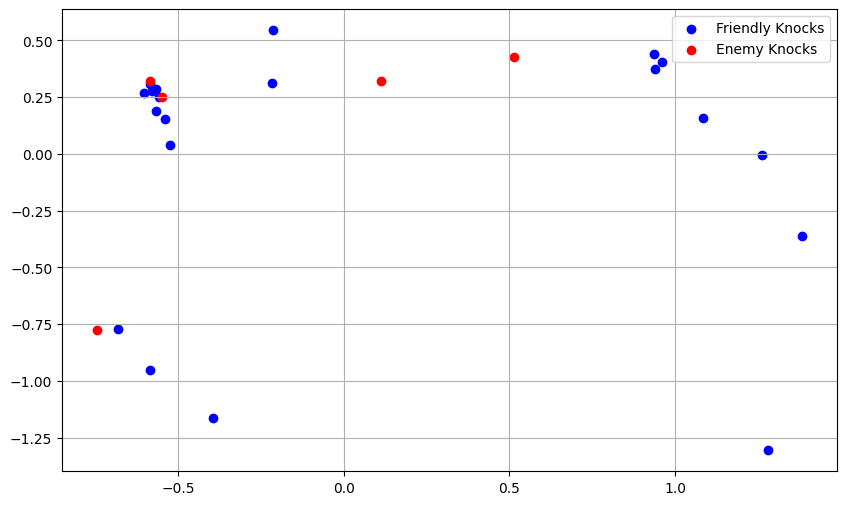

In [145]:
pca = PCA(n_components=2)
all_features = np.vstack([friendly_feature_matrix, enemy_feature_matrix])
reduced_features_pca = pca.fit_transform(all_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features_pca[:friendly_feature_matrix.shape[0], 0],
                    reduced_features_pca[:friendly_feature_matrix.shape[0], 1],
                    c='blue', label='Friendly Knocks')
plt.scatter(reduced_features_pca[friendly_feature_matrix.shape[0]:, 0],
            reduced_features_pca[friendly_feature_matrix.shape[0]:, 1],
            c='red', label='Enemy Knocks')
plt.legend()
plt.grid(True)
plt.show()